In [1]:
from SimPEG import Mesh
from simpegem1d import *
%pylab inline

Populating the interactive namespace from numpy and matplotlib


# Set up for EM1D program

## Step1: Generate mesh

In [2]:
nearthick = np.logspace(-1, 1, 5)
deepthick = np.logspace(1, 2, 10)
hx = np.r_[nearthick, deepthick]
mesh1D = Mesh.TensorMesh([hx], [0.])
depth = -mesh1D.gridN[:-1]
LocSigZ = -mesh1D.gridCC
nlay = depth.size
topo = np.r_[0., 0., 100.]

## Step2: Set survey parameters

In [3]:
FDsurvey = BaseEM1D.EM1DSurveyFD()
FDsurvey.rxLoc = np.array([0., 0., 100.+1e-5])
FDsurvey.srcLoc = np.array([0., 0., 100.+1e-5])
FDsurvey.fieldtype = 'secondary'
FDsurvey.rxType = 'Hz'
FDsurvey.srcType = 'VMD'
# Switch txType if you want circular loop (do not use offset)
# FDsurvey.a = 10.
# FDsurvey.txType = 'CircularLoop'
FDsurvey.offset = 8.
FDsurvey.depth = depth
FDsurvey.topo = topo
FDsurvey.LocSigZ = LocSigZ
FDsurvey.frequency = np.logspace(-2, 8, 61)
FDsurvey.Nfreq = FDsurvey.frequency.size
FDsurvey.Setup1Dsystem()
FDsurvey.SetOffset()

## Step3: Set mappings (Exponential and Cole-Cole maps)

### Exponential map

### $$ m = log(\sigma) $$

### $$ M_{exp}(m) = e^{m}$$

### Cole-Cole map

$$ m(\sigma_{\infty}, \eta, \tau, c; \omega) = \sigma_{\infty} - \sigma_{\infty}\eta \frac{1}{1+(1-\eta)(\imath\omega\tau)^c}$$

In [4]:
sig_half = 1e0
chi_half = 0.
options = {'Frequency': FDsurvey.frequency, 'tau': np.ones(nlay)*0.002, 'eta':np.ones(nlay)*0.5, 'c':np.ones(nlay)*1.}
Expmap = BaseEM1D.BaseEM1DMap(mesh1D)
Colemap = BaseEM1D.BaseColeColeMap(mesh1D, **options)*Expmap

In [5]:
m_1D = np.log(np.ones(nlay)*sig_half)

In [7]:
%%time
WT0, WT1, YBASE = DigFilter.LoadWeights()
options = {'WT0': WT0, 'WT1': WT1, 'YBASE': YBASE}
prob = EM1D.EM1D(mesh1D, sigmaMap=Expmap, **options)

if prob.ispaired:
    prob.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
prob.pair(FDsurvey)
prob.CondType = 'Real'
prob.chi = np.zeros(FDsurvey.nlay)
Hz = prob.fields(m_1D)

CPU times: user 199 ms, sys: 5.26 ms, total: 204 ms
Wall time: 220 ms


In [8]:
%%time
options = {'WT0': WT0, 'WT1': WT1, 'YBASE': YBASE}
probcole = EM1D.EM1D(mesh1D, sigmaMap = Colemap, **options)
if probcole.ispaired:
    probcole.unpair()
if FDsurvey.ispaired:
    FDsurvey.unpair()
probcole.pair(FDsurvey)
probcole.chi = np.zeros(FDsurvey.nlay)
probcole.CondType = 'Complex'
HzCole = probcole.fields(m_1D)
Hzanal = EM1DAnal.Hzanal(sig_half, FDsurvey.frequency, FDsurvey.offset, 'secondary')

CPU times: user 228 ms, sys: 3.75 ms, total: 231 ms
Wall time: 249 ms


Text(10000,1e-08,u'$\\tau$ = 0.1')

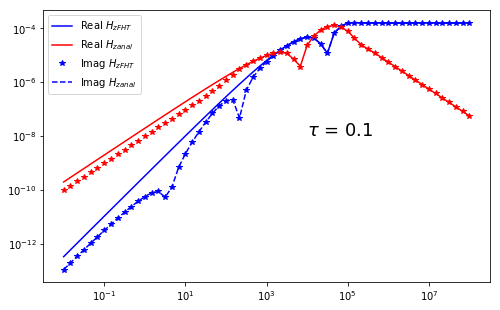

In [9]:
fig, ax = plt.subplots(1,1, figsize = (8, 5))
ax.loglog(FDsurvey.frequency, abs(Hz.real), 'b')
ax.loglog(FDsurvey.frequency, abs(Hz.imag), 'r')
ax.loglog(FDsurvey.frequency, abs(HzCole.real), 'b*')
ax.loglog(FDsurvey.frequency, abs(HzCole.real), 'b--')
ax.loglog(FDsurvey.frequency, abs(HzCole.imag), 'r*')
legend(('Real $H_{z FHT}$', 'Real $H_{z anal}$', 'Imag $H_{z FHT}$', 'Imag $H_{z anal}$'))
ax.text(1e4, 1e-8, "$\\tau$ = 0.1", fontsize = 18)